In [ ]:
!pip install python-graphblas

# Библиотеки


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread
from typing import List
import time
import sys
import random


# Задание 1 и 2

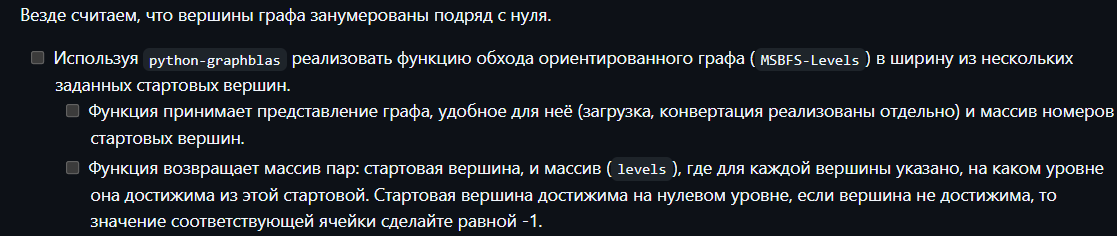

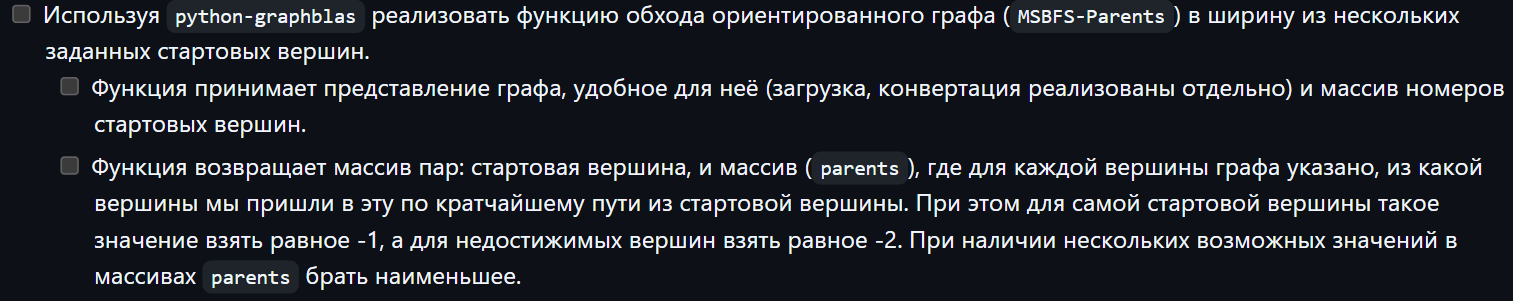

In [ ]:
def MSBFS_Levels(M:Matrix, s: List[int]):
  n = M.nrows #определеям кол-во вершин
  result_1 = Matrix(dtypes.INT32, len(s), n) #создаем матрицу для хранения результатов
  f_1 = Matrix(bool, len(s), n) #создаем фронт вершин
  for i in range(len(s)):
    f_1[i, s[i]] << True #присваиваем начальным вершинам тру
  level = 0
  for level in range(n-1):
    result_1(mask=f_1.V) << level #Записываем результат во фронт
    level += 1
    f_1_before = f_1.dup() #Создаем копию фронта для сравнения
    #перезаписываем результат, используем комплименатрую маску вектора результата (берем струткуру .S)
    f_1(~result_1.S, replace=True) << f_1.mxm(M, semiring.lor_land) # Матричное умножение в полукольце булевом для вычисления следующего фронта вершин
    if f_1.isequal(f_1_before):  # Если фронт не изменился, то прерываем цикл
      break
  pairs = []

  for i in range(result_1.shape[0]):
      result_app = result_1[i, :]
      pairs.append([s[i], result_app.to_dense(fill_value=-1).tolist()])
  return pairs


def MSBFS_Parents(A:Matrix, s: List[int]):
    N = A.nrows  #определеям кол-во вершин
    index_ramp = Matrix(dtypes.UINT64, len(s), N)
    parents = Matrix(dtypes.UINT64, len(s), N)
    row_indices = []
    col_indices = []
    values = []
    for i in range(len(s)):
        for j in range(N):
            row_indices.append(i)
            col_indices.append(j)
            values.append(j)
    index_ramp.build(row_indices, col_indices, values)
    for i in range(len(s)):
        parents[i, s[i]] << N + 1  #Уставновка значения стартовых вершин, чтобы потом поменяться на -1
    wavefront = Matrix(dtypes.UINT64, len(s), N)
    for i in range(len(s)):
        wavefront[i, s[i]] << 0

    while wavefront.nvals > 0:  # Проверка на ненулевые значения
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first)
        parents(binary.plus) << wavefront

    pairs = []
    for i in range(parents.shape[0]):
        parents_app = parents[i, :]
        pairs.append([s[i], [(-1 if val > N else int(val)) for val in parents_app.to_dense(fill_value=-2).tolist()]])

    return pairs


# Тесты для 1 и 2 задания

In [ ]:
def test_for_MSBFS(function_MSBFS):
    # Тест 1
    adjacency_matrix = np.array([
        [0, 1, 1, 0, 1, 0],
        [1, 0, 1, 1, 0, 0],
        [1, 1, 0, 1, 1, 1],
        [0, 1, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 1],
        [0, 0, 1, 1, 1, 0]
    ])
    A = Matrix.from_dense(adjacency_matrix, dtype=dtypes.INT64)
    gb.viz.draw(A.dup(mask=A.dup(dtype=dtypes.BOOL)))
    s = [1, 2, 5]  # стартовые вершины
    print(f'Стартовые вершины:', *s)
    print("Test 1 Result:", function_MSBFS(A, s))

    # Тест 2
    edges = [
        [3, 0, 3, 5, 6, 0, 6, 2, 4, 1],
        [0, 1, 2, 2, 2, 3, 3, 5, 5, 6],
    ]
    B = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
    gb.viz.draw(B.dup(mask=B.dup(dtype=dtypes.BOOL)))
    s = [0, 4, 5]
    print(f'Стартовые вершины:', *s)
    print("Test 2 Result:", function_MSBFS(B, s))

    # Тест 3
    edges = [
        [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
        [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    ]
    C = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
    gb.viz.draw(C.dup(mask=C.dup(dtype=dtypes.BOOL)))
    s = [1]
    print(f'Стартовые вершины:', *s)
    print("Test 3 Result:", function_MSBFS(C, s))




# Тест для MSBFS_Levels

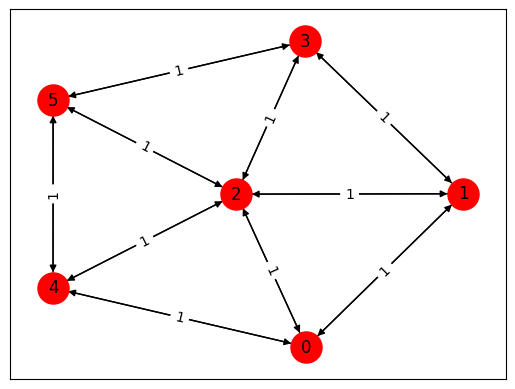

Стартовые вершины: 1 2 5
Test 1 Result: [[1, [1, 0, 1, 1, 2, 2]], [2, [1, 1, 0, 1, 1, 1]], [5, [2, 2, 1, 1, 1, 0]]]


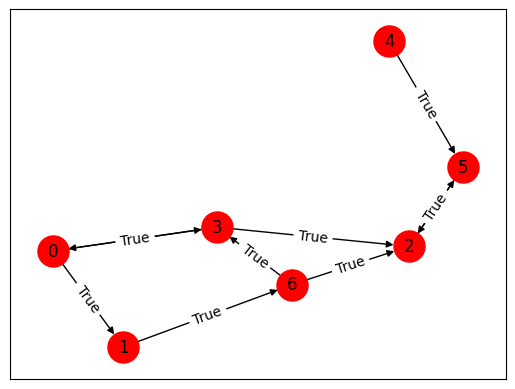

Стартовые вершины: 0 4 5
Test 2 Result: [[0, [0, 1, 2, 1, -1, 3, 2]], [4, [-1, -1, 2, -1, 0, 1, -1]], [5, [-1, -1, 1, -1, -1, 0, -1]]]


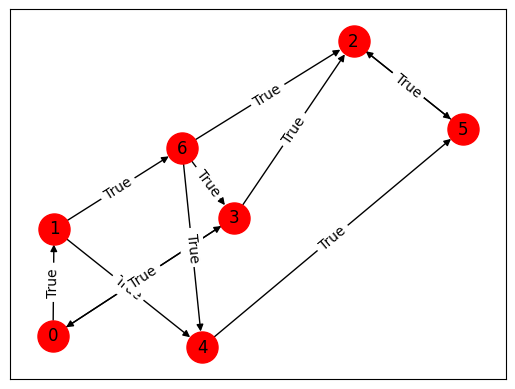

Стартовые вершины: 1
Test 3 Result: [[1, [3, 0, 2, 2, 1, 2, 1]]]


In [ ]:
# Запуск N
test_for_MSBFS(MSBFS_Levels)

# Тест для MSBFS_Parents

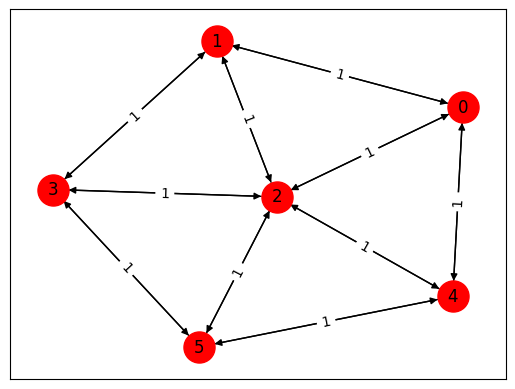

Стартовые вершины: 1 2 5
Test 1 Result: [[1, [1, -1, 1, 1, 1, 1]], [2, [2, 2, -1, 2, 2, 2]], [5, [5, 5, 5, 5, 5, -1]]]


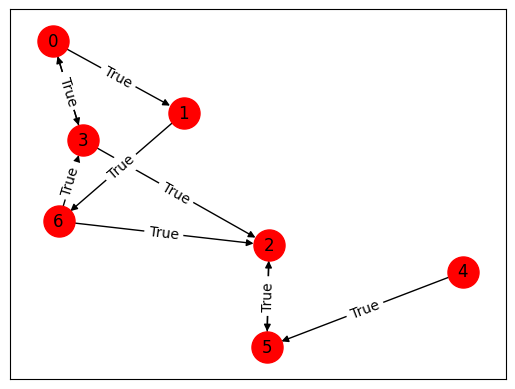

Стартовые вершины: 0 4 5
Test 2 Result: [[0, [-1, 0, 3, 0, -2, 2, 1]], [4, [-2, -2, 5, -2, -1, 4, -2]], [5, [-2, -2, 5, -2, -2, -1, -2]]]


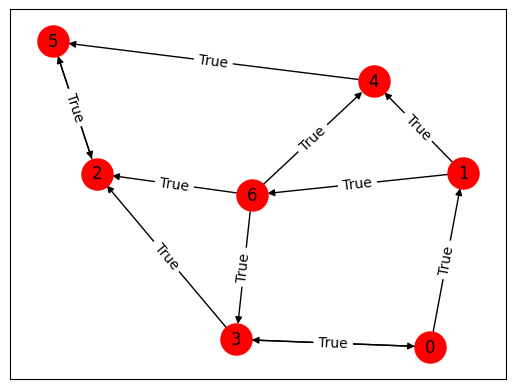

Стартовые вершины: 1
Test 3 Result: [[1, [3, -1, 6, 6, 1, 4, 1]]]


In [ ]:
# Запуск тестов для MSBFS_Parents
test_for_MSBFS(MSBFS_Parents)

# Задание 3

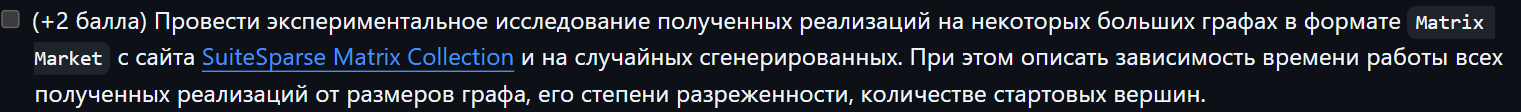

In [ ]:
A1 = mmread('/content/crack.mtx')
A2 = mmread('/content/cti.mtx')

## Большие графы

In [ ]:
def test_BFS(G):
    # Генерация случайных стартовых вершин
    num_vertices = G.nrows #кол-во вершин
    num_edges = len(G.to_coo()[0]) #Кол-во ребер
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1)) if num_vertices > 1 else 0 #разряженность

    num_starting_vertices_list = [1, 5, 10, 100, 250,500]  # Возможные количества стартовых вершин
    data = []  # Список для хранения результатов

    for num_starting_vertices in num_starting_vertices_list:
        s = random.sample(range(G.nrows), num_starting_vertices)  # Выбор случайных вершин

        functions = [MSBFS_Levels, MSBFS_Parents]  # Запоминаем функции для выполнения
        for func in functions:
            start_time = time.time()
            result = func(G, s)  # Передаем граф и список стартовых вершин
            end_time = time.time()

            # Запись данных
            data.append((num_vertices, num_edges, rerefaction_deg ,num_starting_vertices, func.__name__, end_time - start_time))

    # Создание DataFrame для представления данных
    df = pd.DataFrame(data, columns=['Кол-во вершин','Кол-во ребер','Степень разряженности','Кол-воо стартовых вершин', 'Алгоритм', 'Время (сек.)'])

    # Печать данных
    return df

In [ ]:
test_BFS(A1)

,Кол-во вершин,Кол-во ребер,Степень разряженности,Кол-воо стартовых вершин,Алгоритм,Время (сек.)
0,10240,60760,0.00058,1,MSBFS_Levels,0.024017
1,10240,60760,0.00058,1,MSBFS_Parents,0.032138
2,10240,60760,0.00058,5,MSBFS_Levels,0.088662
3,10240,60760,0.00058,5,MSBFS_Parents,0.116097
4,10240,60760,0.00058,10,MSBFS_Levels,0.176572
5,10240,60760,0.00058,10,MSBFS_Parents,0.359179
6,10240,60760,0.00058,100,MSBFS_Levels,2.561581
7,10240,60760,0.00058,100,MSBFS_Parents,2.939855
8,10240,60760,0.00058,250,MSBFS_Levels,5.690500
9,10240,60760,0.00058,250,MSBFS_Parents,8.813351


In [ ]:
test_BFS(A2)

,Кол-во вершин,Кол-во ребер,Степень разряженности,Кол-воо стартовых вершин,Алгоритм,Время (сек.)
0,16840,96464,0.00034,1,MSBFS_Levels,0.037609
1,16840,96464,0.00034,1,MSBFS_Parents,0.058233
2,16840,96464,0.00034,5,MSBFS_Levels,0.085274
3,16840,96464,0.00034,5,MSBFS_Parents,0.094515
4,16840,96464,0.00034,10,MSBFS_Levels,0.088538
5,16840,96464,0.00034,10,MSBFS_Parents,0.196120
6,16840,96464,0.00034,100,MSBFS_Levels,1.125757
7,16840,96464,0.00034,100,MSBFS_Parents,1.791301
8,16840,96464,0.00034,250,MSBFS_Levels,5.142111
9,16840,96464,0.00034,250,MSBFS_Parents,4.547148


## Выводы для задания 3 - Большие графы

1. **Влияние количества стартовых вершин:**
   - При увеличении количества стартовых вершин время выполнения обоих алгоритмов (`MSBFS_Levels` и `MSBFS_Parents`) действительно возрастает. Это связано с тем, что увеличение числа стартовых вершин увеличивает размерность строк фронта, что усложняет операцию матричного умножения.


2. **Влияние размеров графа:**
   - При увеличении размеров графа (количество вершин и ребер) время выполнения обоих алгоритмов также возрастает. Это связано с увеличением количества столбцов в матрицах, что усложняет операцию матричного умножения.

3. **Сравнение алгоритмов `MSBFS_Levels` и `MSBFS_Parents`:**
   - В целом, алгоритм `MSBFS_Parents` работает медленнее, чем `MSBFS_Levels`, особенно при увеличении количества стартовых вершин и размеров графа.


### Заключение:
- Увеличение количества стартовых вершин и размеров графа значительно влияет на время выполнения обоих алгоритмов.
- Алгоритм `MSBFS_Parents` демонстрирует более значительное увеличение времени выполнения по сравнению с `MSBFS_Levels` при увеличении количества стартовых вершин и размеров графа.

# Cлучайные графы

Тестирование зависимости от числа вершин:

Количество вершин: 100, степень разреженности: 0.70, доля стартовых вершин: 60%
Тестирование MSBFS_Levels: Время выполнения: 0.011616 секунд
Тестирование MSBFS_Parents: Время выполнения: 0.020083 секунд

Количество вершин: 200, степень разреженности: 0.70, доля стартовых вершин: 60%
Тестирование MSBFS_Levels: Время выполнения: 0.025481 секунд
Тестирование MSBFS_Parents: Время выполнения: 0.116019 секунд

Количество вершин: 400, степень разреженности: 0.70, доля стартовых вершин: 60%
Тестирование MSBFS_Levels: Время выполнения: 0.125085 секунд
Тестирование MSBFS_Parents: Время выполнения: 0.461262 секунд

Количество вершин: 800, степень разреженности: 0.70, доля стартовых вершин: 60%
Тестирование MSBFS_Levels: Время выполнения: 0.498756 секунд
Тестирование MSBFS_Parents: Время выполнения: 2.524485 секунд

Тестирование зависимости от степени разреженности:

Количество вершин: 600, степень разреженности: 0.20, доля стартовых вершин: 60%
Тестирова

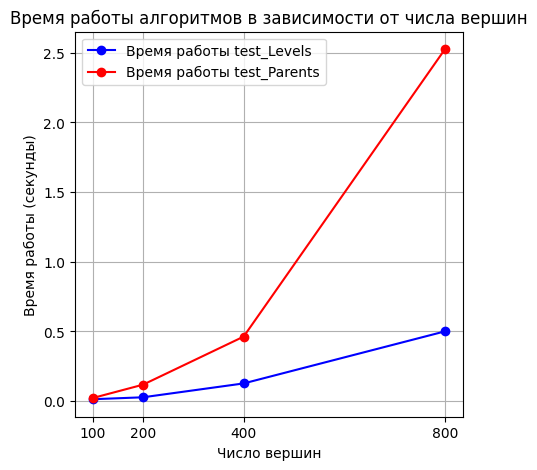

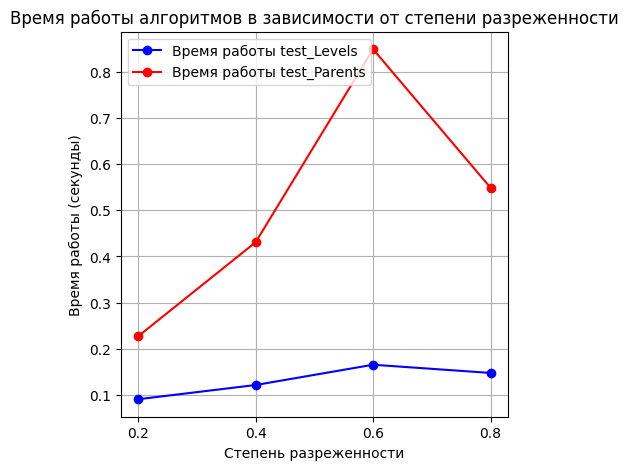

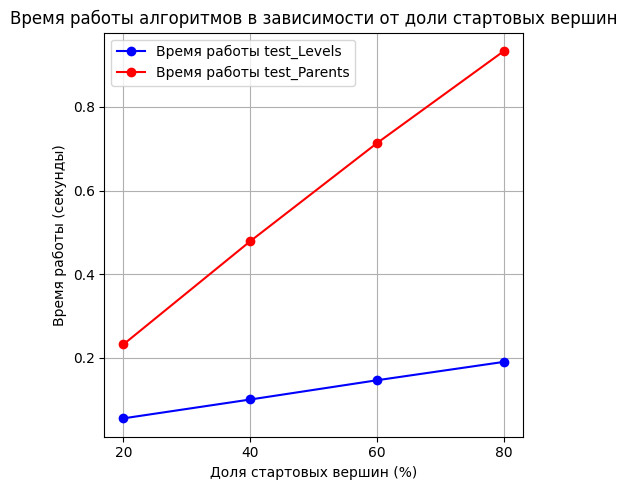

In [ ]:
# Функции для тестирования
def gen_vertices(num_vertices, vertex_frac):
    """Генерация стартовых вершин в зависимости от числа вершин и доли стартовых вершин."""
    start_vertices = random.sample(range(num_vertices), int(vertex_frac / 100 * num_vertices))
    return np.array(start_vertices)

def test_Levels(A, start_vertices):
    """Тестирование функции MSBFS_Levels."""
    start_time = time.time()
    MSBFS_Levels(A, start_vertices)
    elapsed_time = time.time() - start_time
    return elapsed_time

def test_Parents(A, start_vertices):
    """Тестирование функции MSBFS_Parents."""
    start_time = time.time()
    MSBFS_Parents(A, start_vertices)
    elapsed_time = time.time() - start_time
    return elapsed_time

# Генерация случайного графа
def generate_graph(num_vertices, num_edges):
    """Генерация случайного графа с заданным числом вершин и ребер."""
    positions = [ind for ind in range(num_vertices**2) if ind // num_vertices != ind % num_vertices]
    gen_indices = random.sample(positions, num_edges)
    row_indices, col_indices = np.unravel_index(gen_indices, (num_vertices, num_vertices))
    return gb.Matrix.from_coo(row_indices, col_indices, [1]*len(row_indices), nrows=num_vertices, ncols=num_vertices)

# Тестирование на случайно сгенерированных графах
def run_tests():
    """Запуск тестов с различными параметрами."""
    results = []
    time_levels_vertices = []
    time_parents_vertices = []
    time_levels_sparsity = []
    time_parents_sparsity = []
    time_levels_start_frac = []
    time_parents_start_frac = []

    # Фиксированные параметры
    fix_raref_deg = 0.7
    num_starts = 60

    # Зависимость от числа вершин
    print("Тестирование зависимости от числа вершин:\n")
    for num_vertices in [100, 200, 400, 800]:
        generated_graph = generate_graph(num_vertices, int(fix_raref_deg * num_vertices * (num_vertices - 1)))
        num_edges = generated_graph.nvals
        rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
        print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
        time_levels = test_Levels(generated_graph, gen_vertices(num_vertices, num_starts))
        time_parents = test_Parents(generated_graph, gen_vertices(num_vertices, num_starts))
        results.append(["Число вершин", num_vertices, rerefaction_deg, num_starts, time_levels, time_parents])
        time_levels_vertices.append(time_levels)
        time_parents_vertices.append(time_parents)
        print(f'Тестирование MSBFS_Levels: Время выполнения: {time_levels:.6f} секунд')
        print(f'Тестирование MSBFS_Parents: Время выполнения: {time_parents:.6f} секунд\n')

    # Зависимость от степени разреженности
    print("Тестирование зависимости от степени разреженности:\n")
    num_vert = 600
    for raref_deg in [0.2, 0.4, 0.6, 0.8]:
        generated_graph = generate_graph(num_vert, int(raref_deg * num_vert * (num_vert - 1)))
        num_edges = generated_graph.nvals
        rerefaction_deg = num_edges / (num_vert * (num_vert - 1))
        print(f'Количество вершин: {num_vert}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
        time_levels = test_Levels(generated_graph, gen_vertices(num_vert, num_starts))
        time_parents = test_Parents(generated_graph, gen_vertices(num_vert, num_starts))
        results.append(["Степень разреженности", num_vert, rerefaction_deg, num_starts, time_levels, time_parents])
        time_levels_sparsity.append(time_levels)
        time_parents_sparsity.append(time_parents)
        print(f'Тестирование MSBFS_Levels: Время выполнения: {time_levels:.6f} секунд')
        print(f'Тестирование MSBFS_Parents: Время выполнения: {time_parents:.6f} секунд\n')

    # Зависимость от доли стартовых вершин
    print("Тестирование зависимости от доли стартовых вершин:\n")
    x_values = [20, 40, 60, 80]
    for start_frac in x_values:
        generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert - 1)))
        num_edges = generated_graph.nvals
        rerefaction_deg = num_edges / (num_vert * (num_vert - 1))
        print(f'Количество вершин: {num_vert}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {start_frac}%')
        time_levels = test_Levels(generated_graph, gen_vertices(num_vert, start_frac))
        time_parents = test_Parents(generated_graph, gen_vertices(num_vert, start_frac))
        results.append(["Доля стартовых вершин", num_vert, rerefaction_deg, start_frac, time_levels, time_parents])
        time_levels_start_frac.append(time_levels)
        time_parents_start_frac.append(time_parents)
        print(f'Тестирование MSBFS_Levels: Время выполнения: {time_levels:.6f} секунд')
        print(f'Тестирование MSBFS_Parents: Время выполнения: {time_parents:.6f} секунд\n')

    # Создание таблицы результатов
    df = pd.DataFrame(results, columns=["Тест", "Количество вершин", "Степень разреженности", "Доля стартовых вершин", "Время MSBFS_Levels", "Время MSBFS_Parents"])

    # Построение графиков
    plt.figure(figsize=(5, 5))

    # График зависимости от числа вершин
    plt.plot([100, 200, 400, 800], time_levels_vertices, marker='o', label='Время работы test_Levels', color='blue')
    plt.plot([100, 200, 400, 800], time_parents_vertices, marker='o', label='Время работы test_Parents', color='red')
    plt.title('Время работы алгоритмов в зависимости от числа вершин')
    plt.xlabel('Число вершин')
    plt.ylabel('Время работы (секунды)')
    plt.xticks([100, 200, 400, 800])
    plt.legend()
    plt.grid()

    # Построение графиков
    plt.figure(figsize=(5, 5))
    # График зависимости от степени разреженности
    plt.plot([0.2, 0.4, 0.6, 0.8], time_levels_sparsity, marker='o', label='Время работы test_Levels', color='blue')
    plt.plot([0.2, 0.4, 0.6, 0.8], time_parents_sparsity, marker='o', label='Время работы test_Parents', color='red')
    plt.title('Время работы алгоритмов в зависимости от степени разреженности')
    plt.xlabel('Степень разреженности')
    plt.ylabel('Время работы (секунды)')
    plt.xticks([0.2, 0.4, 0.6, 0.8])
    plt.legend()
    plt.grid()

    # Построение графиков
    plt.figure(figsize=(5, 5))
    # График зависимости от доли стартовых вершин
    plt.plot(x_values, time_levels_start_frac, marker='o', label='Время работы test_Levels', color='blue')
    plt.plot(x_values, time_parents_start_frac, marker='o', label='Время работы test_Parents', color='red')
    plt.title('Время работы алгоритмов в зависимости от доли стартовых вершин')
    plt.xlabel('Доля стартовых вершин (%)')
    plt.ylabel('Время работы (секунды)')
    plt.xticks(x_values)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    return df

# Запуск тестов
df = run_tests()


In [ ]:
df

,Тест,Количество вершин,Степень разреженности,Доля стартовых вершин,Время MSBFS_Levels,Время MSBFS_Parents
0,Число вершин,100,0.7,60,0.011616,0.020083
1,Число вершин,200,0.7,60,0.025481,0.116019
2,Число вершин,400,0.7,60,0.125085,0.461262
3,Число вершин,800,0.7,60,0.498756,2.524485
4,Степень разреженности,600,0.2,60,0.090723,0.227125
5,Степень разреженности,600,0.4,60,0.121483,0.430593
6,Степень разреженности,600,0.6,60,0.165377,0.848344
7,Степень разреженности,600,0.8,60,0.147618,0.548537
8,Доля стартовых вершин,600,0.7,20,0.055487,0.232375
9,Доля стартовых вершин,600,0.7,40,0.100568,0.479115


## Выводы для задания 3 - Случайные графы

Давайте подправим выводы с учетом предоставленных данных:

1. **Влияние числа вершин**:
   - С увеличением числа вершин наблюдается рост времени выполнения обоих алгоритмов. Это обусловлено увеличением количества столбцов в матрицах, что усложняет процесс матричного умножения.
   - Алгоритм `MSBFS_Levels` показывает приблизительно линейную зависимость времени от числа вершин.
   - Алгоритм `MSBFS_Parents` демонстрирует более выраженное увеличение времени, что свидетельствует о степенной зависимости.

2. **Влияние числа стартовых вершин**:
   - С увеличением числа стартовых вершин также наблюдается рост времени выполнения алгоритмов. Это связано с тем, что увеличение стартовых вершин непосредственно влияет на размер строк фронта, что усложняет процесс матричного умножения.
   - Оба алгоритма показывают увеличение времени выполнения с увеличением доли стартовых вершин, что подтверждает зависимость от размера фронта.

3. **Влияние степени разреженности**:
   - С увеличением степени разреженности наблюдается увеличение времени выполнения обоих алгоритмов. Это связано с увеличением количества ребер в графе, что требует больше вычислительных ресурсов для обработки.
   - Однако, при переходе от степени разреженности 0.6 к 0.8 наблюдается небольшое снижение времени выполнения, что может быть связано с особенностями генерации графа или случайными факторами.
   - В целом, алгоритмы работают быстрее на графах со средней степенью разреженности, что может быть объяснено оптимизацией под реальные графы, которые, как правило, не являются почти полными или чрезмерно разреженными.

Таким образом, основные выводы можно сформулировать следующим образом:

1. **Число вершин**: Увеличение числа вершин приводит к росту времени выполнения обоих алгоритмов. `MSBFS_Levels` демонстрирует линейную зависимость, тогда как `MSBFS_Parents` показывает более выраженное увеличение времени.

2. **Число стартовых вершин**: Увеличение числа стартовых вершин также приводит к росту времени выполнения алгоритмов из-за увеличения размера фронта.

3. **Степень разреженности**: Увеличение степени разреженности приводит к увеличению времени выполнения алгоритмов из-за увеличения количества ребер. Однако, алгоритмы работают быстрее на графах со средней степенью разреженности, что может быть связано с их оптимизацией под реальные графы.

# Задача 4

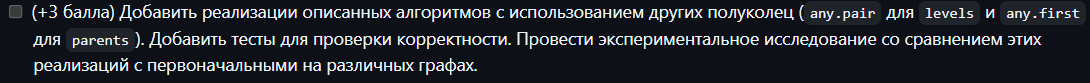

# MSBFS_Levels_AnyPair

In [ ]:
def MSBFS_Levels_AnyPair(M, s):
  n = M.nrows #определеям кол-во вершин
  result_1 = Matrix(dtypes.INT32, len(s), n) #создаем матрицу для хранения результатов
  f_1 = Matrix(bool, len(s), n) #создаем фронт вершин
  for i in range(len(s)):
    f_1[i, s[i]] << True #присваиваем начальным вершинам тру
  level = 0
  for level in range(n-1):
    result_1(mask=f_1.V) << level #Записываем результат во фронт
    level += 1
    f_1_before = f_1.dup() #Создаем копию фронта для сравнения
    #перезаписываем результат, используем комплименатрую маску вектора результата (берем струткуру .S)
    f_1(~result_1.S, replace=True) << f_1.mxm(M, semiring.any_pair) # Матричное умножение в полукольце булевом для вычисления следующего фронта вершин
    # Проверка, достигнута ли хоть одна вершина в следующем фронтири ???
    if f_1.isequal(f_1_before):  # Если фронт не изменился, то прерываем цикл
      break
  pairs = []

  for i in range(result_1.shape[0]):
      result_app = result_1[i, :]  # Получаем i-ю строку
    # Добавляем к парам (индекс, строка)
      pairs.append([s[i], result_app.to_dense(fill_value=-1).tolist()])
  return pairs

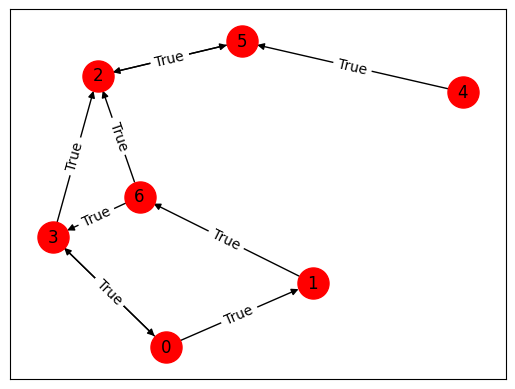

In [ ]:
# Недостижимая вершина 4
edges = [
    [3, 0, 3, 5, 6, 0, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 5, 5, 6],
]
B4 = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
gb.viz.draw(B4.dup(mask=B4.dup(dtype=dtypes.BOOL)))

## Сравнение на маленьких графах

In [ ]:
s = [0,1,2]
MSBFS_Levels(B4,s)

[[0, [0, 1, 2, 1, -1, 3, 2]],
 [1, [3, 0, 2, 2, -1, 3, 1]],
 [2, [-1, -1, 0, -1, -1, 1, -1]]]

In [ ]:
s=[0,1,2]
MSBFS_Levels_AnyPair(B4,s)

[[0, [0, 1, 2, 1, -1, 3, 2]],
 [1, [3, 0, 2, 2, -1, 3, 1]],
 [2, [-1, -1, 0, -1, -1, 1, -1]]]

## Сравнение на больших графах

In [ ]:

def test_BFS_MSBFS_Levels(G):
    num_starting_vertices_list = [1, 5,100, 250,1500, 5000]
    data = []

    for num_starting_vertices in num_starting_vertices_list:
        s = random.sample(range(G.nrows), num_starting_vertices)
        functions = [MSBFS_Levels, MSBFS_Levels_AnyPair]
        results = []

        for func in functions:
            start_time = time.time()
            result = func(G, s)
            end_time = time.time()

            results.append(result)
            data.append((G.nrows, num_starting_vertices, func.__name__, end_time - start_time))
        if results[0] == results[1]:
            match = 1
        else:
            match = 0
        data[-2] = data[-2] + (match,)
        data[-1] = data[-1] + (match,)
    df = pd.DataFrame(data, columns=['Размер графа', 'Кол-во стартовых вершин', 'Алгоритм', 'Время (сек.)', 'Совпадение'])
    return df


In [ ]:
test_BFS_MSBFS_Levels(A1)

,Размер графа,Кол-во стартовых вершин,Алгоритм,Время (сек.),Совпадение
0,10240,1,MSBFS_Levels,0.037771,1
1,10240,1,MSBFS_Levels_AnyPair,0.037842,1
2,10240,5,MSBFS_Levels,0.070618,1
3,10240,5,MSBFS_Levels_AnyPair,0.088940,1
4,10240,100,MSBFS_Levels,0.655041,1
5,10240,100,MSBFS_Levels_AnyPair,0.590968,1
6,10240,250,MSBFS_Levels,1.440045,1
7,10240,250,MSBFS_Levels_AnyPair,1.401033,1
8,10240,1500,MSBFS_Levels,9.310852,1
9,10240,1500,MSBFS_Levels_AnyPair,7.718890,1


## Сравнение на случайных графах

In [ ]:
# Функции для теста
def gen_vertices(num_vertices, vertex_frac):
    #генерация стартовых вершин в зависимости от числа вершин (num_vertices) и доли (в %) стартовых вершин от общего числа (vertex_frac)
    start_vertices = random.sample(range(num_vertices), int(vertex_frac / 100 * num_vertices))
    return np.array(start_vertices)
def test_Levels(A, start_vertices):
    print('msbfs_levels:')
    %timeit MSBFS_Levels(A, start_vertices)
    print()

def test_Levels_anypair(A, start_vertices):
    print('MSBFS_Levels_AnyPair:')
    %timeit MSBFS_Levels_AnyPair(A, start_vertices)
    print()

# Зависимость от числа вершин (при фиксированной степени разреженности и фиксированном числе стартовых вершин)
for i in [100, 200, 2500]:
    fix_raref_deg, num_starts = 0.7, 60  # Фиксированные значения степени разреженности и числа стартовых вершин
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    test_Levels(generated_graph, gen_vertices(i, num_starts))
    test_Levels_anypair(generated_graph, gen_vertices(i, num_starts))

#Степень разряженности
for i in [0.2, 0.4, 0.6, 0.8]:
    num_vert, num_starts = 600, 50
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    test_Levels(generated_graph, gen_vertices(num_vert, num_starts))
    test_Levels_anypair(generated_graph, gen_vertices(num_vert, num_starts))

#Доля стартовых вершин
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 600, 0.7  # Фиксированные число вершин и значение степени разреженности
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {i}%')
    test_Levels(generated_graph, gen_vertices(num_vert, i))
    test_Levels_anypair(generated_graph, gen_vertices(num_vert, i))

Количество вершин: 100, степень разреженности: 0.70, доля стартовых вершин: 60%
msbfs_levels:
14.5 ms ± 5.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

MSBFS_Levels_AnyPair:
11.7 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

Количество вершин: 200, степень разреженности: 0.70, доля стартовых вершин: 60%
msbfs_levels:
22.3 ms ± 995 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

MSBFS_Levels_AnyPair:
22.1 ms ± 897 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество вершин: 2500, степень разреженности: 0.70, доля стартовых вершин: 60%
msbfs_levels:
8.37 s ± 1.55 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Levels_AnyPair:
7.11 s ± 443 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 600, степень разреженности: 0.20, доля стартовых вершин: 50%
msbfs_levels:
90.8 ms ± 32.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

MSBFS_Levels_AnyPair:
68.8 ms ± 1.73 ms per loop (mean ± std. 

## Выводы для MSBFS_Levels_AnyPair

1. **При небольших размерах графа и малой доле стартовых вершин:**
   - Алгоритм `MSBFS_Levels` справляется с задачей быстрее, особенно при повышенной или заниженной степени разряженности.

2. **При увеличении плотности графа, его размера и числа стартовых вершин:**
   - Применение полукольца `AnyPair` способствует сокращению времени выполнения.


3. **Сравнение алгоритмов `MSBFS_Levels` и `MSBFS_Levels_AnyPair`:**
   - При небольших размерах графа и малой доле стартовых вершин `MSBFS_Levels` может быть быстрее.
   - Однако, при увеличении размеров графа, плотности и числа стартовых вершин `MSBFS_Levels_AnyPair` демонстрирует лучшие результаты по времени выполнения.

### Заключение:
- При небольших размерах графа и малой доле стартовых вершин алгоритм `MSBFS_Levels` может быть предпочтительнее.
- При увеличении размеров графа, его плотности и числа стартовых вершин алгоритм `MSBFS_Levels_AnyPair` демонстрирует лучшие результаты по времени выполнения.

# MSBFS_Parents_AnyFirst

In [ ]:
def MSBFS_Parents_AnyFirst(A, s):
    N = A.nrows  #определеям кол-во вершин
    index_ramp = Matrix(dtypes.UINT64, len(s), N)
    parents = Matrix(dtypes.UINT64, len(s), N)
    row_indices = []
    col_indices = []
    values = []
    for i in range(len(s)):
        for j in range(N):
            row_indices.append(i)
            col_indices.append(j)
            values.append(j)
    index_ramp.build(row_indices, col_indices, values)
    for i in range(len(s)):
        parents[i, s[i]] << N + 1  #Уставновка значения стартовых вершин, чтобы потом поменяться на -1
    wavefront = Matrix(dtypes.UINT64, len(s), N)
    for i in range(len(s)):
        wavefront[i, s[i]] << 0

    while wavefront.nvals > 0:  # Проверка на ненулевые значения
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.any_first)
        parents(binary.plus) << wavefront
    pairs = []
    for i in range(parents.shape[0]):
        parents_app = parents[i, :]
        pairs.append([s[i], [(-1 if val > N else int(val)) for val in parents_app.to_dense(fill_value=-2).tolist()]])

    return pairs


## Сравнение на маленьких графах

In [ ]:
s = [0,4]
MSBFS_Parents(B4,s)

[[0, [-1, 0, 3, 0, -2, 2, 1]], [4, [-2, -2, 5, -2, -1, 4, -2]]]

In [ ]:
s = [0,4]
MSBFS_Parents_AnyFirst(B4,s)

[[0, [-1, 0, 3, 0, -2, 2, 1]], [4, [-2, -2, 5, -2, -1, 4, -2]]]

## Сравнение на случайных графах

In [ ]:
# Функции для теста
def gen_vertices(num_vertices, vertex_frac):
    #генерация стартовых вершин в зависимости от числа вершин (num_vertices) и доли (в %) стартовых вершин от общего числа (vertex_frac)
    start_vertices = random.sample(range(num_vertices), int(vertex_frac / 100 * num_vertices))
    return np.array(start_vertices)
def test_Parents_MinFirst(A, start_vertices):
    print('MSBFS_Parents_MinFirst:')
    %timeit MSBFS_Parents(A, start_vertices)
    print()

def test_Parents_AnyFirst(A, start_vertices):
    print('MSBFS_Parents_AnyFirst:')
    %timeit MSBFS_Parents_AnyFirst(A, start_vertices)
    print()

# Зависимость от числа вершин (при фиксированной степени разреженности и фиксированном числе стартовых вершин)
for i in [100, 200, 500,1000]:
    fix_raref_deg, num_starts = 0.7, 60  # Фиксированные значения степени разреженности и числа стартовых вершин
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    test_Parents_MinFirst(generated_graph, gen_vertices(i, num_starts))
    test_Parents_AnyFirst(generated_graph, gen_vertices(i, num_starts))

#Степень разряженности
for i in [0.2, 0.4, 0.6, 0.8]:
    num_vert, num_starts = 600, 50
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    test_Parents_MinFirst(generated_graph, gen_vertices(num_vert, num_starts))
    test_Parents_AnyFirst(generated_graph, gen_vertices(num_vert, num_starts))

#Доля стартовых вершин
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 600, 0.7  # Фиксированные число вершин и значение степени разреженности
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {i}%')
    test_Parents_MinFirst(generated_graph, gen_vertices(num_vert, i))
    test_Parents_AnyFirst(generated_graph, gen_vertices(num_vert, i))

Количество вершин: 100, степень разреженности: 0.70, доля стартовых вершин: 60%
MSBFS_Parents_MinFirst:
19.9 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

MSBFS_Parents_AnyFirst:
32.8 ms ± 7.91 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

Количество вершин: 200, степень разреженности: 0.70, доля стартовых вершин: 60%
MSBFS_Parents_MinFirst:
69 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

MSBFS_Parents_AnyFirst:
48.5 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество вершин: 500, степень разреженности: 0.70, доля стартовых вершин: 60%
MSBFS_Parents_MinFirst:
557 ms ± 159 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_AnyFirst:
800 ms ± 214 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, степень разреженности: 0.70, доля стартовых вершин: 60%
MSBFS_Parents_MinFirst:
4 s ± 990 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_AnyFirst

## Выводы для MSBFS_Parents_AnyFirst


1. **При небольших размерах графа и малой доле стартовых вершин:**
   - Алгоритм `MSBFS_Parents_MinFirst` справляется с задачей быстрее, особенно при повышенной или заниженной степени разряженности.

2. **При увеличении плотности графа, его размера и числа стартовых вершин:**
   - Применение полукольца `AnyFirst` способствует сокращению времени выполнения.


3. **Сравнение алгоритмов `MSBFS_Parents_MinFirst` и `MSBFS_Parents_AnyFirst`:**
   - При небольших размерах графа и малой доле стартовых вершин `MSBFS_Parents_MinFirst` может быть быстрее.
   - Однако, при увеличении размеров графа, плотности и числа стартовых вершин `MSBFS_Parents_AnyFirst` демонстрирует лучшие результаты по времени выполнения.

4. **Влияние характеристик графа на производительность:**
   - По мере того как характеристики графов становятся ближе к реальным задачам, алгоритм `MSBFS_Parents_AnyFirst` демонстрирует аналогичную производительность с `MSBFS_Parents_MinFirst` при небольших значениях.
   - Это объясняется тем, что выбор первого элемента и поиск минимального элемента могут быть эффективными подходами в различных сценариях.
   - При увеличении количества стартовых вершин, `MSBFS_Parents_MinFirst` показывает значительно лучшую производительность, что, вероятно, связано с оптимизированной схемой выбора минимального элемента.

### Заключение:
- При небольших размерах графа и малой доле стартовых вершин алгоритм `MSBFS_Parents_MinFirst` может быть предпочтительнее.
- При увеличении размеров графа, его плотности и числа стартовых вершин алгоритм `MSBFS_Parents_AnyFirst` демонстрирует лучшие результаты по времени выполнения.